In [9]:
!pip install nilearn

# **Python implementation of Structural Decoupling Index**

**Reference:**
1. Preti, Maria Giulia, and Dimitri Van De Ville. "Decoupling of brain function from structure reveals regional behavioral specialization in humans." Nature communications 10.1 (2019): 1-7.



**The framework of Structural Decoupling Index**

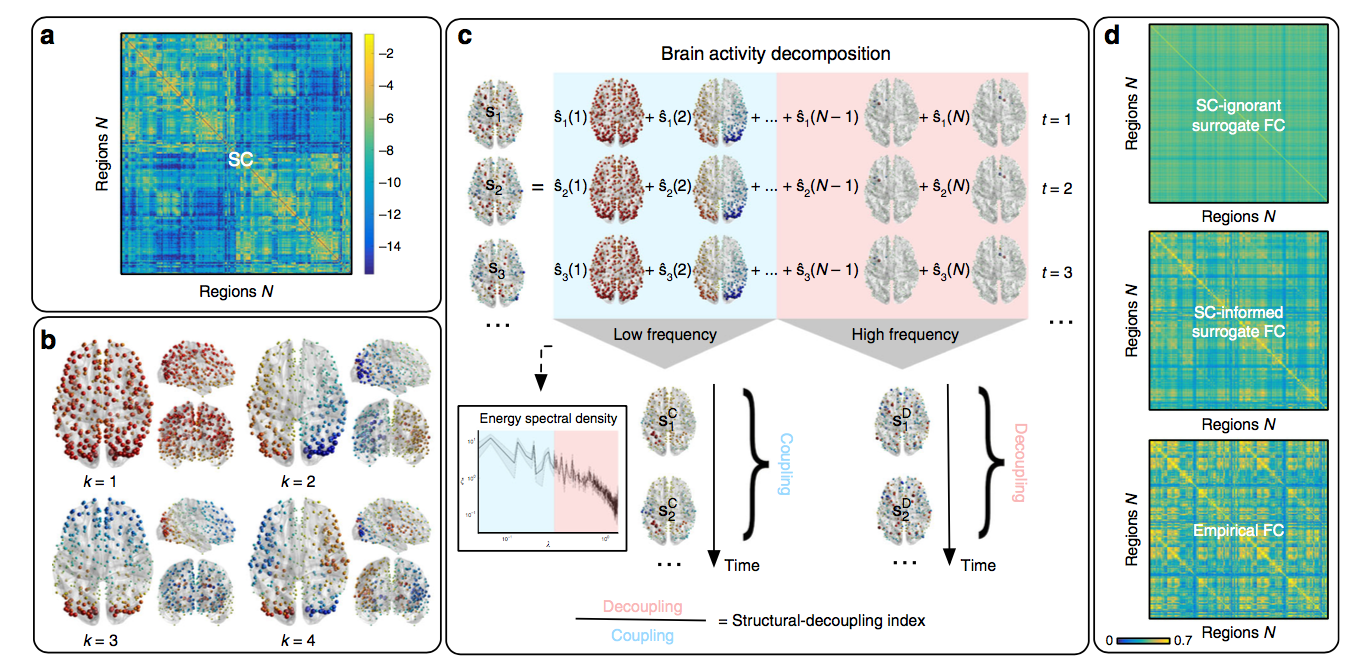

### **Load Data**

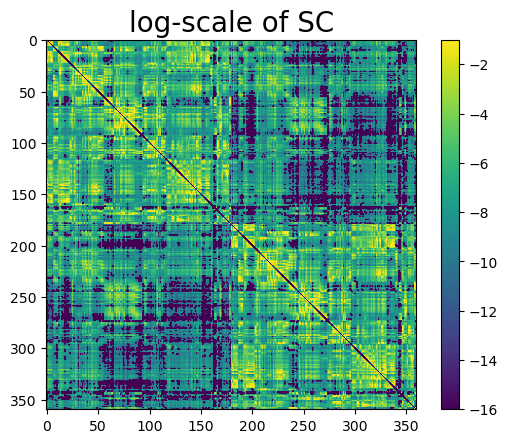

In [10]:
from scipy.io import loadmat
import numpy as np

avg_sc = np.array(loadmat('./data/SDI/SC_avg56.mat')['SC_avg56'])
time_series = np.array(loadmat('./data/SDI/X_RS_10subjects.mat')['X_RS'])

num_of_subject=time_series.shape[2]
num_of_region=time_series.shape[0]
time_length=time_series.shape[1]

from scipy.stats import zscore
zX_RS=zscore(time_series,axis=1)

import matplotlib.pyplot as plt
avg_sc_disp=avg_sc.copy()
avg_sc_disp[np.where(avg_sc == 0)]=0.0000000000000000000000000001


plt.imshow(np.log(avg_sc_disp),cmap='viridis',vmax=-1,vmin=-16)
plt.title('log-scale of SC',fontsize=20)
plt.colorbar()



**Obtain Laplacian Matrix of SC**

In [11]:
import numpy as np
Degree_=np.diag(np.power(np.sum(avg_sc,0),-0.5))#
SC_normalized=np.matmul(np.matmul(Degree_,avg_sc),Degree_)

Laplace_SC=np.eye(avg_sc.shape[0])-SC_normalized

**Obtain structural harmonics (structural basis)**

In [12]:
eigenvalues, eigenvectors=np.linalg.eig(Laplace_SC)

# reorder eigenvalues
indexs=np.argsort(eigenvalues)
eigv_sort=eigenvalues[indexs]
U_=eigenvectors[:,indexs]


**Visualization of Structural Harmonics**

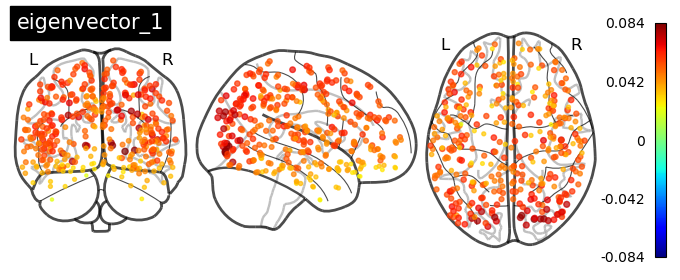

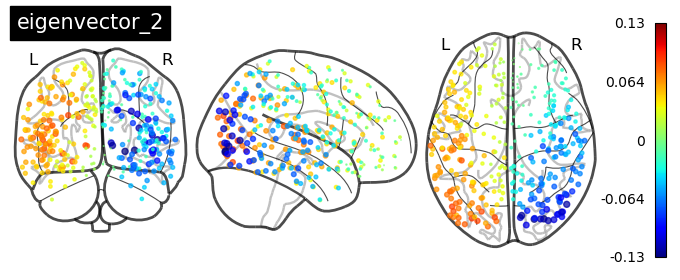

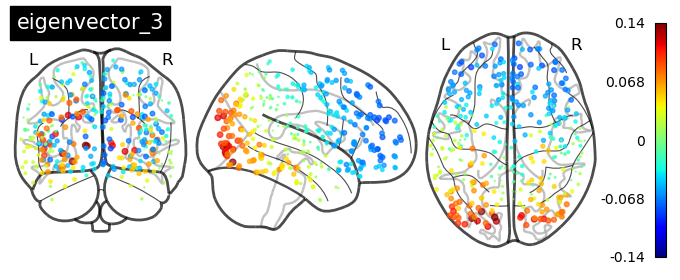

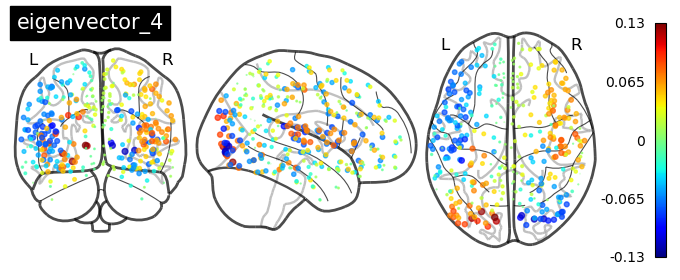

In [13]:
from nilearn import plotting
# Coords
mmpatlas = './data/Glasser_space-MNI152NLin6_res-2x2x2.nii.gz'
atlas_region_coords_left = plotting.find_parcellation_cut_coords(mmpatlas, label_hemisphere='left')
atlas_region_coords_right = plotting.find_parcellation_cut_coords(mmpatlas, label_hemisphere='right')
coords = np.vstack([atlas_region_coords_left, atlas_region_coords_right])



# plot the corresponding eigenvectors of the smallest 4 eigenvalues.
for i in range(4):
    title_='eigenvector_'+str(i+1)
    # Plot
    plotting.plot_markers(
        node_values=U_[:,i],
        node_coords=coords,
        title=title_,
        node_cmap='jet',
        node_size=20*np.abs(U_[:,i])/np.maximum(np.max(U_[:,i]),np.abs(np.min(U_[:,i]))),
        node_vmin=-np.maximum(np.max(U_[:,i]),np.abs(np.min(U_[:,i]))),
        node_vmax=np.maximum(np.max(U_[:,i]),np.abs(np.min(U_[:,i])))
    )

### **Average Energy Spectral Density of Resting-state Functional data Projected on the Structural Harmonics**

In [14]:
# rs Functional data projected on the Structural Harmonics

X_hat_ = np.zeros((num_of_region,time_length,num_of_subject))
for i in range(num_of_subject):
    X_hat_[:,:,i]=np.matmul(np.transpose(U_),zX_RS[:,:,i])

pow = np.abs(X_hat_)**2
PSD=np.mean(pow,axis=1)

avg=np.mean(PSD,axis=1)
stdPSD=np.std(PSD,axis=1)

upperl=avg+stdPSD
lowerl=avg-stdPSD

**Compute Cut-off Frequency**

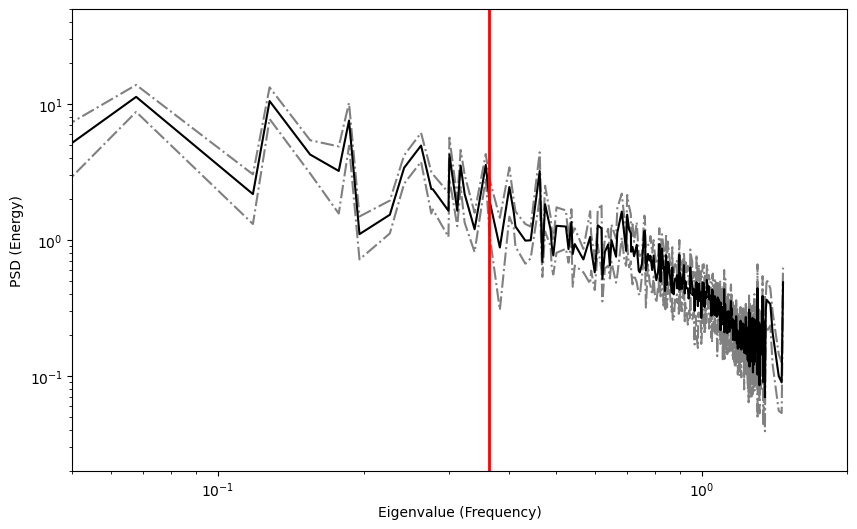

In [15]:
mPSD = np.mean(PSD,1)
AUCTOT = np.trapz(mPSD)

i=0
AUC=0
while AUC<AUCTOT/2:
    AUC=np.trapz(mPSD[:i])
    i+=1

CUTOFF_Freq_ind=i-1


import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(eigv_sort,upperl,'-.',color='grey')
plt.plot(eigv_sort,lowerl,'-.',color='grey')
plt.plot(eigv_sort,avg,'-',color='black')
plt.xlim([0.05,2])
plt.ylim([0.02,50])
plt.axvline(x=eigv_sort[CUTOFF_Freq_ind],linewidth=2,color='red')
plt.xlabel('Eigenvalue (Frequency)')
plt.ylabel('PSD (Energy)')
plt.xscale('log')
plt.yscale('log')

**Split structural harmonics in high/low frequency**

In [16]:
# Laplacian eigenvectors flipped in order (high frequencies first)
U_flip=np.fliplr(U_)
Vhigh=np.zeros(U_flip.shape)
Vlow=np.zeros(U_flip.shape)

Vhigh[:,:(num_of_region-CUTOFF_Freq_ind)]=U_flip[:,:(num_of_region-CUTOFF_Freq_ind)]
Vlow[:,(num_of_region-CUTOFF_Freq_ind):]=U_flip[:,(num_of_region-CUTOFF_Freq_ind):]

**Compute fMRI HF/LF portions**


In [17]:
X_high=np.zeros((num_of_region,time_length,num_of_subject))
X_low=np.zeros((num_of_region,time_length,num_of_subject))

coupling_norm=np.zeros((num_of_region,num_of_subject))
decoupling_norm=np.zeros((num_of_region,num_of_subject))

for i in range(num_of_subject):
    X_hat_=np.matmul(np.transpose(U_flip),zX_RS[:,:,i])
    X_low[:,:,i]=np.matmul(Vlow,X_hat_) # Projected into low frequency band
    X_high[:,:,i]=np.matmul(Vhigh,X_hat_) # Projected into high frequency band

    for j in range(num_of_region):
        coupling_norm[j,i]=np.linalg.norm(X_low[j,:,i]) # norm of the projected series in low frequency band
        decoupling_norm[j,i]=np.linalg.norm(X_high[j,:,i]) # norm of the projected series in high frequency band

mean_coupling=np.mean(coupling_norm,1)
mean_decoupling=np.mean(decoupling_norm,1)


mean_SDI=np.divide(mean_decoupling,mean_coupling) # empirical AVERAGE SDI
SDI=np.divide(decoupling_norm,coupling_norm) # emipirical individual SDI


**Visualization of the SDI among all brain regions**

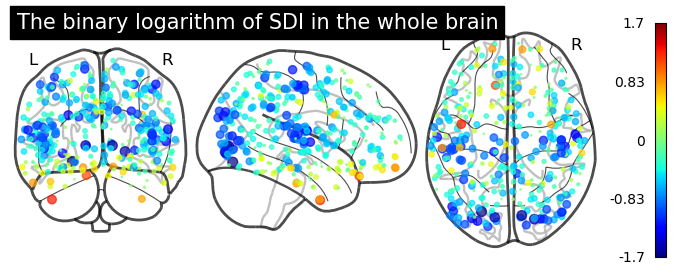

In [18]:

title_='The binary logarithm of SDI in the whole brain'
# Plot
plotting.plot_markers(
    node_values=np.log2(mean_SDI),
    node_coords=coords,
    title=title_,
    node_cmap='jet',
    node_size=50*np.abs(np.log2(mean_SDI))/np.maximum(np.max(np.log2(mean_SDI)),np.abs(np.min(np.log2(mean_SDI)))),
    node_vmin=-np.maximum(np.max(np.log2(mean_SDI)),np.abs(np.min(np.log2(mean_SDI)))),
    node_vmax=np.maximum(np.max(np.log2(mean_SDI)),np.abs(np.min(np.log2(mean_SDI))))
)